<a href="https://colab.research.google.com/github/ethompson93/dmri_analysis_techniques/blob/main/constrained_spherical_deconvolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Constrained spherical deconvolution


In this coding assignment, we'll be performing constrained spherical deconvolution with DIPY (https://dipy.org). DIPY is an open-source python library for diffusion MRI processing and analysis.

Using the same sample data as the previous exercise, download from https://drive.google.com/drive/folders/12hHKJoAXDB-AsNTzxXf4ZvSbfq-_7qmX?usp=share_link and upload it to this Google collab.

## The data

This coding exercise uses the [Fibercup phantom](https://tractometer.org/fibercup/home/). Fibercup is a simple phantom designed to mimic fibre configurations that are commonly found in the human brain, such as crossing and kissing fibre bundles, which are difficult to reconstruct with tractography

## Loading Variables

We'll use the same code from the previous exercises to load in the dataset.

This involves: importing  necessary libraries: nibabel to load our nifti images as numpy arrays; and numpy to run mathematical steps on these arrays.

In [ ]:
## Import libaries
import nibabel as nb
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

In [ ]:
# install dipy and import relevant functions
! pip install dipy
from dipy.core.gradients import gradient_table
from dipy.reconst.csdeconv import response_from_mask_ssst
from dipy.sims.voxel import single_tensor_odf
from dipy.data import default_sphere
from dipy.reconst.csdeconv import ConstrainedSphericalDeconvModel
from dipy.direction import peaks_from_model

# uncomment the following if you are running locally and want to visualise the results
# from dipy.viz import actor, window

In [ ]:
## Nifti Images

# Load our nifti image as "dwi_img" and get data to "dwi"
dwi_img = nb.load('fibrecup.nii.gz')
dwi = dwi_img.get_fdata()
affine = dwi_img.affine

# repeat this with the white matter mask
mask_img = nb.load('wm_mask.nii.gz')
mask = mask_img.get_fdata()

## Gradient information
# Load our gradient text file at grad
grad = np.loadtxt('grad.txt')

# select our gradient direction as "g"
g = grad[:,0:3]

# select our b-values as "b"
b = grad[:,3]

## Reshaping
# find the index of the voxels within the white matter mask
idx = np.where(mask>0)
print(np.shape(idx))

# extract dwi values at these WM voxels to produce a matrix of
# [WM voxels x grad-dirs]. Save this as "dwi_wm"
dwi_wm = dwi[idx[0],idx[1],idx[2]]

## Extracting b0 & non-b0 diffusion signals
# find from gradients where the b-value is equal to zero as "b0idx"
b0idx = np.where(b==0)[0]

# find from gradients where the b-value is NOT equal to zero as "non_b0idx"
non_b0idx = np.where(b!=0)[0]

# Extract baseline signal ("S0") by indexing "dwi" at b0idx
S0 = dwi_wm[:,b0idx]

# Extract gradient weighted signal ("S") by indexing the "dwi" at non-b0 values
S = dwi_wm[:,non_b0idx]

## Visualising the data


In [ ]:
# make a figure with three subplots for b=0, b=2000 and the wm mask
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(dwi[:,:,1,0].T, origin="lower")
axs[0].set_title("b=0")
axs[1].imshow(np.mean(dwi[:,:,1,1:], axis=2).T, origin="lower")
axs[1].set_title("average b=2000")
axs[2].imshow(mask[:,:,1].T, origin="lower")
axs[2].set_title("white matter mask")
plt.show()

## Estimating the Fibre Response Function




First, we need to put the gradient information into the format required by DIPY, using the `gradient_table` function.


In [ ]:
grad_tab = gradient_table(bvals=b, bvecs=g)

Next, we will use the DIPY function `response_from_mask_ssst` to obtain the fibre response function from voxels within a mask. Ideally, the mask will cover voxels containing a single coherent fibre population. We have created a mask called `single_fibre_pop_mask.nii.gz`, which we will use as input to the function. First, we can visualise the mask; check that you're happy with the regions we have chosen.

In [ ]:
# visualise the mask
single_fib_mask = nb.load("single_fibre_pop_mask.nii.gz").get_fdata()
plt.imshow(mask[:,:,1].T, origin="lower")
plt.imshow(single_fib_mask[:,:,1].T, origin="lower", alpha=0.5)

This mask is used as an input into the `response_from_mask_ssst` function, along with the gradient table and the data.

This function returns two values, the response function and the ratio between smallest versus largest eigenvalue of the response.

In [ ]:
response, ratio = response_from_mask_ssst(grad_tab, dwi, single_fib_mask)

The `response` variable consists of two elements. The first is an array with the eigenvalues of the response function. The second element is the average B0 signal for this response function.

In [ ]:
print(response)

`ratio` is the ratio between the smallest versus the largest eigenvalue of the response

In [ ]:
print(ratio)

We can visualise the fODF corresponding to the response function using DIPY tools. This won't work on google colab, but you can try it if you're running the notebook locally. We've included the output below.

---



In [ ]:
'''
# Enables/disables interactive visualization
interactive = False

scene = window.Scene()
evals = response[0]
evecs = np.array([[0, 1, 0], [0, 0, 1], [1, 0, 0]]).T


response_odf = single_tensor_odf(default_sphere.vertices, evals=evals, evecs=evecs)
# transform our data from 1D to 4D
response_odf = response_odf[None, None, None, :]
response_actor = actor.odf_slicer(
    response_odf, sphere=default_sphere, colormap="plasma"
)
scene.add(response_actor)
print("Saving illustration as csd_response.png")
window.record(scene=scene, out_path="csd_response.png", size=(200, 200))
if interactive:
    window.show(scene)
'''

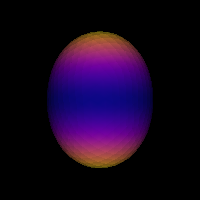

Since the phantom data is quite noisy and has low anisotropy, the estimated response function looks more spherical than we would usually see in real data. An example of a Fibre Response function estimated from a dMRI scan in a human brain is shown below:

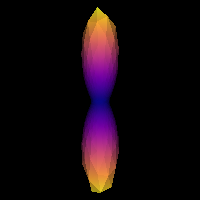

## Performing Constrained Spherical Deconvolution

Next, we will use constrained spherical deconvolution to estimate the fODF in each voxel, by deconvolving the measured signal with the response function that we calculated in the previous step.

We set up a `csd_model` using the `ConstrainedSphericalDeconvModel` function, with the gradient table and the response function as inputs. We can then fit the model to our data using the `fit` function.

We also have to chose the maximum order of spherical harmonic basis function to use. Information about spherical harmonic bases here: [https://docs.dipy.org/stable/theory/sh_basis](https://docs.dipy.org/stable/theory/sh_basis.html#)

In [ ]:
sh_order_max = 6 # maximum order of the spherical harmonic basis to use
csd_model = ConstrainedSphericalDeconvModel(gtab=grad_tab,
                                           response=response,
                                           sh_order_max=sh_order_max)

csd_fit = csd_model.fit(dwi)

sh_coeffs = csd_fit.shm_coeff

We can use DIPY tools to visualise the fODFs:

Again, this won't work on colab but we've included the results below.

In [ ]:
'''
csd_odf = csd_fit.odf(default_sphere)
fodf_spheres = actor.odf_slicer(
    csd_odf, sphere=default_sphere, scale=0.9, norm=False, colormap="plasma"
)

scene.add(fodf_spheres)
print("Saving illustration as csd_odfs.png")
window.record(scene=scene, out_path="csd_odfs.png", size=(1000,1000))
if interactive:
    window.show(scene)
'''

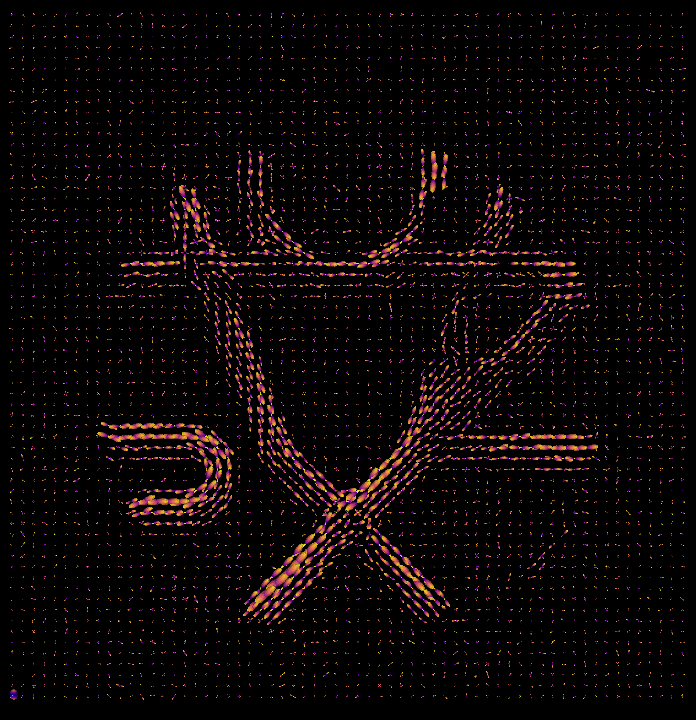

`peaks_from_model` finds the maxima of the ODFs in each voxel - this provides an estimate of the fibre orientations, which can be used for tractography.

In [ ]:
csd_peaks = peaks_from_model(model=csd_model,
                             data=dwi,
                             sphere=default_sphere,
                             relative_peak_threshold=.5,
                             min_separation_angle=25,
                             parallel=True)

We can visualise the peaks as in the previous exercises. Compare them with your results from the tensor representation and the ball-and-stick.

In [ ]:
# Choose a slice in which you will visualise the principal direction
slice = 0
peak = 0

# Considering only the x and y components, plot a quiver plot of the prinicpal
# direction in each white matter voxel in this slice
# see matplotlib.pyplot.quiver documentation:
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.quiver.html

u = csd_peaks.peak_dirs[:,:,slice, peak, 0]
v = csd_peaks.peak_dirs[:,:,slice, peak, 1]

# scale by peak values
u = u * csd_peaks.peak_values[:,:,slice, peak]
v = v * csd_peaks.peak_values[:,:,slice, peak]

fig = plt.figure
plt.quiver(u.T,v.T, scale_units='x', scale=1)

plt.show()

In [ ]:
prediction = csd_model.predict(sh_coeffs, gtab=grad_tab, S0=dwi[:,:,:,0])

prediction_wm = prediction[idx[0],idx[1],idx[2]]

SSE = np.sum((prediction_wm - dwi_wm)**2, axis=1)

SSE_map = np.zeros_like(mask)
SSE_map[idx[0],idx[1],idx[2]] = SSE

plt.imshow(SSE_map[:,:,1].T, origin="lower", vmax=10000)
plt.colorbar()
plt.show()

print(f"median sum-of-squared error = {np.median(SSE)}")